## Replication of: "Vulnerable Growth" Adrian et al. (2019), using Euro Area data

### Part 1

In [1]:
# Importing necessary libraries
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.dates import DateFormatter
import os

#We set the working directory (useful to chose the folder where to export output files)
os.chdir('/Users/JABAMI/Desktop/Cours_Sorbonne_FTD/Quantitative_Methods/devoir/rep_vuln_growth/')


# Load the data
df = pd.read_excel('data/Data_Adrian_2019_usa&EA.xlsx', sheet_name='EA_Quarterly') 
df.index = pd.to_datetime(df.Date)  # Convert Date to DatetimeIndex
df.sort_index(inplace=True)
# Add a constant (intercept) directly to df as a new co5lumn
df['Intercept'] = 1


# Define which column is the dependent variable (based on h). 
h = 1  # Change this to 4 for YoY.

if h == 1:
    ycol = 'g_RGDP'
    label_text = "GDP Growth 1 Quarter Ahead (QoQA)"
elif h == 4:
    ycol = 'g_RGDPyoy'
    label_text = "GDP Growth 4 Quarters Ahead (YoY)"

Prediction: shift GDP growth to see if we can predict it

In [2]:
# Replace the dependent variable with its shifted values
df[ycol] = df[ycol].shift(-h)

# Drop rows with NaN values in the 'CISS' or dependent variable
df.dropna(subset=['CISS', ycol], inplace=True)

Functions

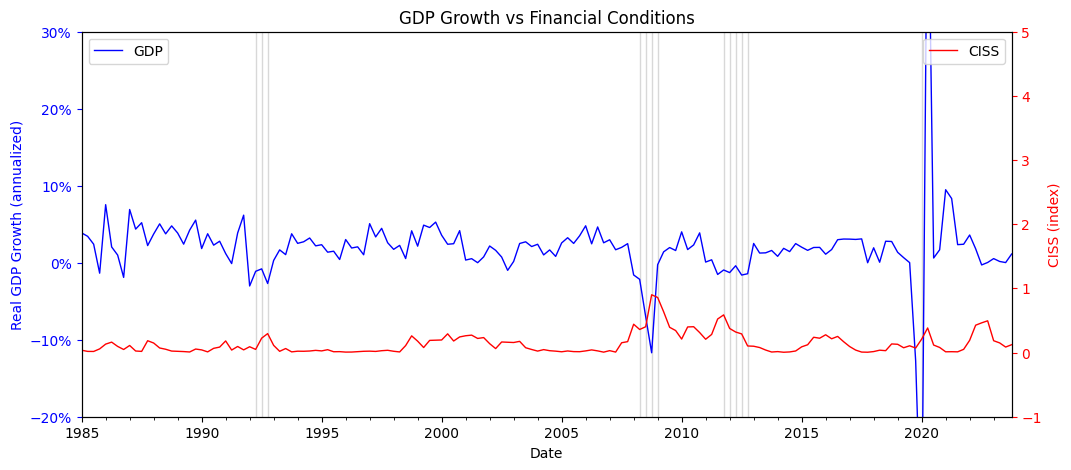

In [3]:
# Function to get recession dates from the dataset
def get_recession_dates(df, recession_indicator_column):
    """
    Identify recession start and end dates based on the recession indicator column.
    """
    start_dates = []
    end_dates = []
    T = len(df)

    for t in range(T):
        date_aux = df.index[t]  # Assuming the DataFrame index is the date
        x_aux = df[recession_indicator_column].iloc[t]

        if x_aux == 1:
            # Determine the start and end of the recession
            year_aux = date_aux.year
            quarter_aux = (date_aux.month - 1) // 3 + 1
            start_date = pd.Timestamp(f"{year_aux}-{quarter_aux * 3 - 2}-01")
            end_date = pd.Timestamp(f"{year_aux}-{quarter_aux * 3}-01") + pd.offsets.QuarterEnd(0)

            # Add start and end dates to the list
            start_dates.append(start_date)
            end_dates.append(end_date)

    # Combine start and end dates into a list of tuples
    recession_dates = list(zip(start_dates, end_dates))
    return recession_dates

# Get the recession dates from the DataFrame
df['Recession'] = ((df[ycol] < 0) & (df[ycol].shift(1) < 0)).astype(int)
recession_dates = get_recession_dates(df, 'Recession')


# Function to add recession shading to plots
def add_recession_shading(ax, recession_dates, color='gray', alpha=0.3):
    """
    Add shaded areas to represent recession periods on a given axis.
    """
    for start_date, end_date in recession_dates:
        ax.axvspan(start_date, end_date, color=color, alpha=alpha)



# Plot the GDP growth and the CISS
plt.figure(figsize=(12, 5))
# Plotting GDP Growth (ycol) on the primary y-axis
ax = df[ycol].plot(label='GDP', linewidth=1, color='b')
ax.set_ylim([-20, 30])
ax.tick_params(axis='y', colors='b')  
ax.set_ylabel('Real GDP Growth (annualized)', color='b')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())  # Format y-axis as percentage
# Add recession shading
add_recession_shading(ax, recession_dates)
# Plotting CISS on the secondary y-axis
ax2 = ax.twinx()
df['CISS'].plot(ax=ax2, label='CISS', linewidth=1, color='r')
ax2.set_ylabel('CISS (index)', color='r')  
ax2.tick_params(axis='y', colors='r')  
ax2.set_ylim([-1, 5])
# Setting up the legend and title
plt.title('GDP Growth vs Financial Conditions')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
# Display the improved plot
plt.show()

Scatter plot setup

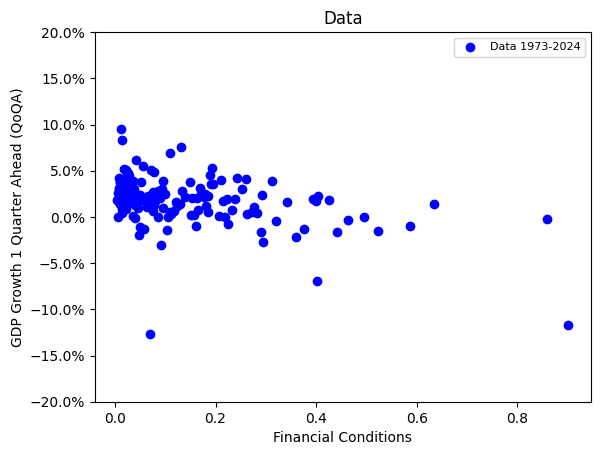

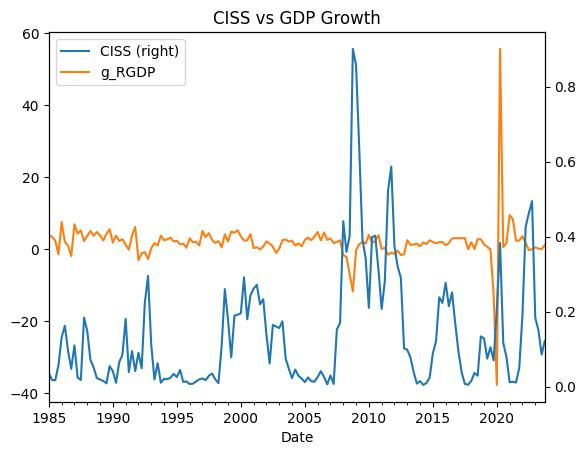

In [4]:
yaxis_bounds_aux = [-20, 20]  # Define y-axis bounds
plt.scatter(df.CISS, df[ycol], c='b', label='Data 1973-2024')
# Labels and title
plt.xlabel('Financial Conditions')
plt.ylabel(label_text)
plt.ylim(yaxis_bounds_aux)
plt.title('Data')
# Format y-axis as percentage (if needed)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
# Add legend
plt.legend(loc='best', fontsize=8)
# Display the plot
plt.show()

# Plot CISS and shifted GDP growth on two different y-axes
df.loc[:, ['CISS', ycol]].plot(secondary_y='CISS')
plt.title('CISS vs GDP Growth')
plt.savefig('fig/Adrian_2019_fig1.pdf')
plt.show()

Linear regression

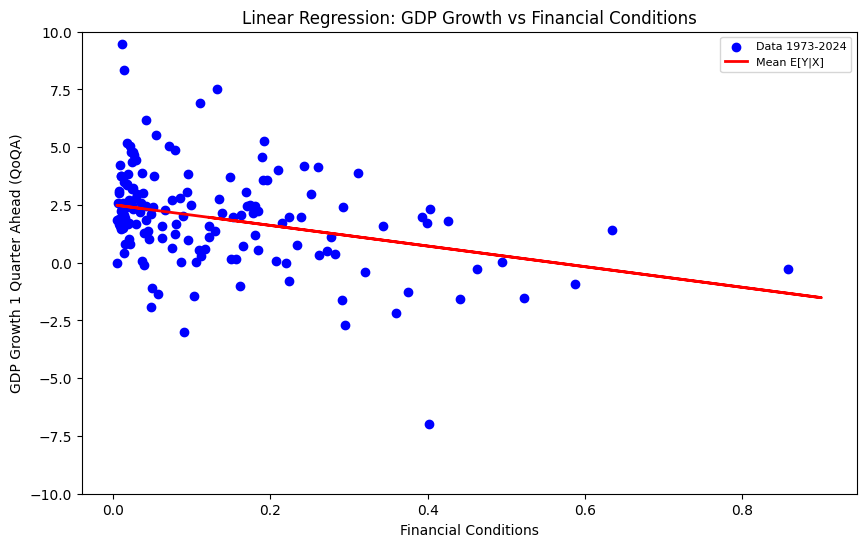

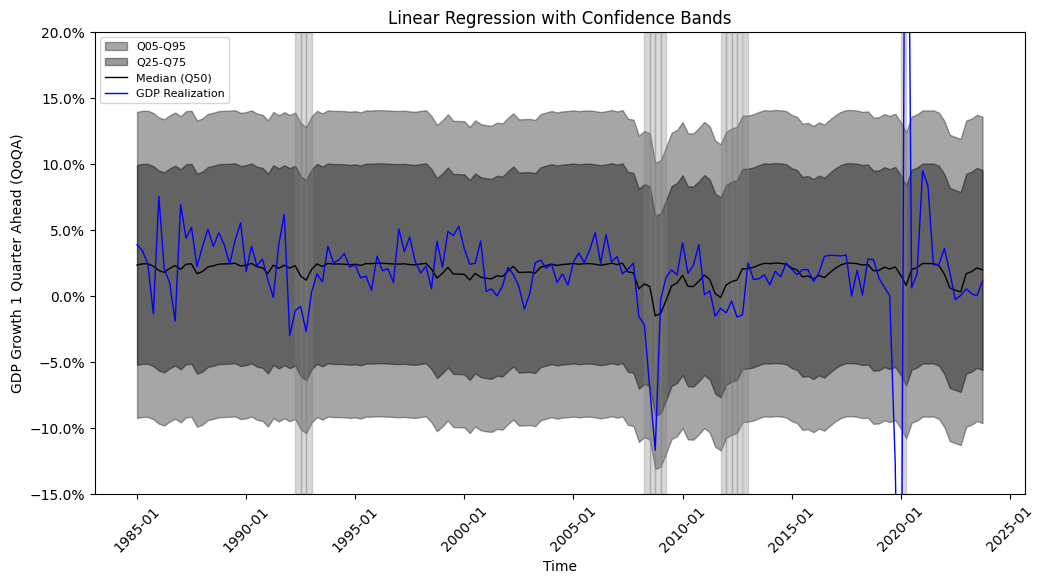

In [5]:
# Prepare the matrix (CISS column for X, and ycol for y)
X = df['CISS']
y = df[ycol]

# Add a constant (intercept term) to the predictor matrix
X_with_intercept = sm.add_constant(X)

# Fit the linear regression model using statsmodels
model = sm.OLS(y, X_with_intercept).fit()

# Get the fitted values (predictions)
predictions = model.predict(X_with_intercept)

# Scatter plot setup
plt.figure(figsize=(10, 6))

# Scatter plot of CISS vs GDP Growth
plt.scatter(X, y, c='b', label='Data 1973-2024')
# Plot the regression line
plt.plot(X, predictions, 'r', label='Mean E[Y|X]', linewidth=2)
# Labels and title
plt.xlabel('Financial Conditions')
plt.ylabel(label_text)
plt.ylim([-10, 10])  # Replace with your specific y-axis bounds if needed
plt.title('Linear Regression: GDP Growth vs Financial Conditions')
# Add legend
plt.legend(loc='best', fontsize=8)
# Display the plot
plt.show()


# Time Series Plot with Confidence Bands
# Generate forecast dates
Dates_forecast_full = df.index
linreg_fitted_full = np.zeros((len(Dates_forecast_full), 5))

# Simulate confidence bands (Replace with actual prediction intervals if available)
linreg_fitted_full[:, 2] = predictions  # Median (Q50)
linreg_sigma = np.std(model.resid)  # Estimate residual standard deviation
linreg_fitted_full[:, 0] = predictions - 1.96 * linreg_sigma  # Q05
linreg_fitted_full[:, 4] = predictions + 1.96 * linreg_sigma  # Q95
linreg_fitted_full[:, 1] = predictions - 1.28 * linreg_sigma  # Q25
linreg_fitted_full[:, 3] = predictions + 1.28 * linreg_sigma  # Q75

# Assume y_full is the original target variable for plotting
y_full = df[ycol]

# Create the figure
plt.figure(figsize=(12, 6))

# Step 1: Plot the confidence bands
plt.fill_between(Dates_forecast_full, linreg_fitted_full[:, 0], linreg_fitted_full[:, 4], color='black', alpha=0.35, label='Q05-Q95')
plt.fill_between(Dates_forecast_full, linreg_fitted_full[:, 1], linreg_fitted_full[:, 3], color='black', alpha=0.4, label='Q25-Q75')

# Step 2: Plot the median (Q50) line
plt.plot(Dates_forecast_full, linreg_fitted_full[:, 2], 'k', linewidth=1, label='Median (Q50)')

# Step 3: Plot the actual GDP realization
plt.plot(Dates_forecast_full, y_full, 'b', linewidth=1, label='GDP Realization')

# Add recession shading
ax = plt.gca()
add_recession_shading(ax, recession_dates)

# Formatting
plt.title('Linear Regression with Confidence Bands')
plt.xlabel('Time')
plt.ylabel(label_text)
plt.ylim([-15, 20])  # Adjust y-axis bounds as needed
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())  # Format y-axis as percentage
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))  # Format x-axis as dates
plt.xticks(rotation=45)

# Add a legend
plt.legend(loc='best', fontsize=8)

# Show the plot
plt.show()

Quantile regression

c:\Users\JABAMI\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


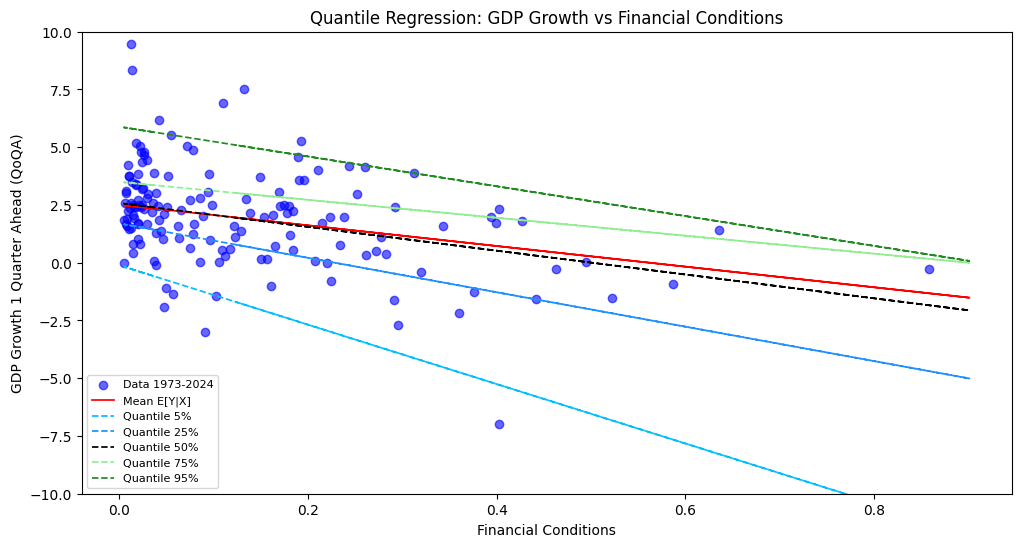

In [6]:
# Step 1: Perform Quantile Regression for different quantile levels
quantile_levels = [0.05, 0.25, 0.5, 0.75, 0.95]  # Quantiles to estimate
quantile_fitted = {}  # Dictionary to store fitted values for each quantile

for quantile in quantile_levels:
    # Fit quantile regression using statsmodels
    quantile_model = sm.QuantReg(y, X_with_intercept).fit(q=quantile)
    quantile_fitted[quantile] = quantile_model.predict(X_with_intercept)

# Step 2: Plotting the Data, Mean Regression, and Quantile Regression Lines
plt.figure(figsize=(12, 6))

# Scatter plot of the original data
plt.scatter(X, y, c='b', label='Data 1973-2024', alpha=0.6)

# Plot the mean linear regression line
plt.plot(X, predictions, 'r', linewidth=1.25, label='Mean E[Y|X]')

# Define colors for the quantile lines
color_map = {
    0.05: 'deepskyblue',  # Lower quantiles - blue shades
    0.25: 'dodgerblue',
    0.5: 'black',         # Median - black
    0.75: 'lightgreen',   # Upper quantiles - green shades
    0.95: 'forestgreen'
}

# Plot the quantile regression lines with different colors
for quantile in quantile_levels:
    plt.plot(X, quantile_fitted[quantile], '--', color=color_map[quantile], linewidth=1.25, label=f'Quantile {quantile*100:.0f}%')


# Formatting
plt.xlabel('Financial Conditions')
plt.ylabel(label_text)
plt.ylim([-10, 10])  # Adjust y-axis bounds if needed
plt.title('Quantile Regression: GDP Growth vs Financial Conditions')
# Add a legend
plt.legend(loc='lower left', fontsize=8)
plt.savefig('fig/Adrian_2019_fig2.pdf')
# Show the plot
plt.show()


Quantile Regression Time Series Plot

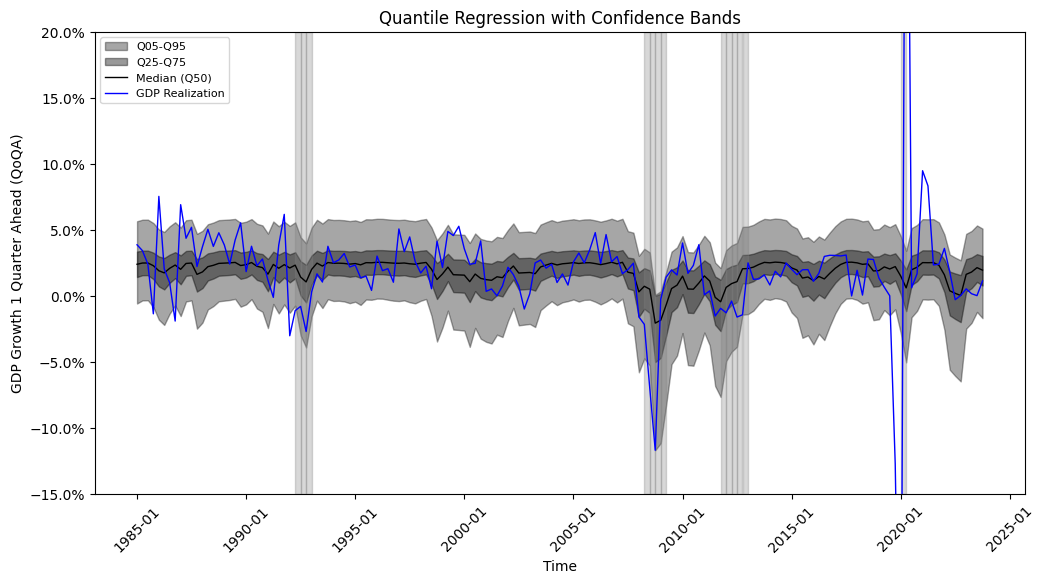

In [7]:
# Create a matrix for quantile regression fitted values (similar to linreg_fitted_full)
quantile_fitted_full = np.zeros((len(Dates_forecast_full), 5))

# Fill the matrix with quantile fitted values for each quantile
quantile_fitted_full[:, 0] = quantile_fitted[0.05]  # Q05
quantile_fitted_full[:, 1] = quantile_fitted[0.25]  # Q25
quantile_fitted_full[:, 2] = quantile_fitted[0.5]   # Q50 (Median)
quantile_fitted_full[:, 3] = quantile_fitted[0.75]  # Q75
quantile_fitted_full[:, 4] = quantile_fitted[0.95]  # Q95

# Create the figure for the quantile regression time series plot
plt.figure(figsize=(12, 6))

# Step 1: Plot the confidence bands
plt.fill_between(Dates_forecast_full, quantile_fitted_full[:, 0], quantile_fitted_full[:, 4], color='black', alpha=0.35, label='Q05-Q95')
plt.fill_between(Dates_forecast_full, quantile_fitted_full[:, 1], quantile_fitted_full[:, 3], color='black', alpha=0.4, label='Q25-Q75')

# Step 2: Plot the median (Q50) line
plt.plot(Dates_forecast_full, quantile_fitted_full[:, 2], 'k', linewidth=1, label='Median (Q50)')

# Step 3: Plot the actual GDP realization
plt.plot(Dates_forecast_full, y_full, 'b', linewidth=1, label='GDP Realization')

# Add recession shading
ax = plt.gca()
add_recession_shading(ax, recession_dates)

# Formatting
plt.title('Quantile Regression with Confidence Bands')
plt.xlabel('Time')
plt.ylabel(label_text)
plt.ylim([-15, 20])  # Adjust y-axis bounds as needed
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())  # Format y-axis as percentage
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))  # Format x-axis as dates
plt.xticks(rotation=45)

# Add a legend
plt.legend(loc='best', fontsize=8)

plt.savefig('fig/Adrian_2019_fig3.pdf')

# Show the plot
plt.show()

### Part 2 : fit distributions, plot 3D densities, and compute the score

In [8]:
# Importing necessary libraries
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import t
from scipy.stats import norm

minimize_iter_max = 50

# Set the working directory (useful to choose the folder where to export output files)
#os.chdir('/Users/skimeur/Mon Drive/empirical_finance/') # --> already set up at the begining of the notebook

# Function to compute the quantile for the skewed t-distribution
def qskt(p, mu, sigma, alpha, nu):
    from scipy.stats import t
    quantile = mu + sigma * t.ppf(p, df=nu) * (1 + alpha * np.sign(p - 0.5))
    return quantile

# Function to perform quantile interpolation for skewed t-distribution
def quantiles_interpolation(quantiles, quantile_targets):
    def objective(params):
        mu, sigma, alpha, nu = params
        theoretical_quantiles = [qskt(q, mu, sigma, alpha, nu) for q in quantile_targets]
        error = np.sum((np.array(theoretical_quantiles) - np.array(quantiles)) ** 2)
        return error

    initial_guess = [0, 1, 0, 5]
    bounds = [(-np.inf, np.inf), (1e-6, np.inf), (-np.inf, np.inf), (2, np.inf)]
    result = minimize(objective, initial_guess, bounds=bounds,options={'maxiter': minimize_iter_max})
    mu, sigma, alpha, nu = result.x
    return mu, sigma, alpha, nu

# Function to calculate the density of the skewed t-distribution
def dskt(x, mu, sigma, alpha, nu):
    """
    Calculate the density of the skewed t-distribution.

    Parameters:
    - x: The points at which to evaluate the density.
    - mu: Location parameter.
    - sigma: Scale parameter.
    - alpha: Skewness parameter.
    - nu: Degrees of freedom.

    Returns:
    - Density values of the skewed t-distribution at the points x.
    """
    # Standardize the input
    z = (x - mu) / sigma
    
    # Compute the skewed t-density
    normalization = 2 / sigma * t.pdf(z, df=nu) * t.cdf(alpha * z * np.sqrt((nu + 1) / (nu + z**2)), df=nu + 1)
    return normalization


# Load the data
df = pd.read_excel('data/Data_Adrian_2019_usa&EA.xlsx', sheet_name='EA_Quarterly') 
df.index = pd.to_datetime(df.Date)  # Convert Date to DatetimeIndex
df.sort_index(inplace=True)
df['Intercept'] = 1  # Add a constant (intercept) directly to df as a new column

# Define which column is the dependent variable (based on h)
h = 1  # Change this to 4 for YoY

if h == 1:
    ycol = 'g_RGDP'
    label_text = "GDP Growth 1 Quarter Ahead (QoQA)"
elif h == 4:
    ycol = 'g_RGDPyoy'
    label_text = "GDP Growth 4 Quarters Ahead (YoY)"

Prediction: shift GDP growth to see if we can predict it

In [9]:
# Replace the dependent variable with its shifted values
df['g_RGDP_original'] = df[ycol]
df[ycol] = df[ycol].shift(-h)


# Drop rows with NaN values in the 'CISS' or dependent variable
df.dropna(subset=['CISS', ycol,'g_RGDP_original'], inplace=True)

# Function to get recession dates from the dataset
def get_recession_dates(df, recession_indicator_column):
    """
    Identify recession start and end dates based on the recession indicator column.
    """
    start_dates = []
    end_dates = []
    T = len(df)

    for ti in range(T):
        date_aux = df.index[ti]  # Assuming the DataFrame index is the date
        x_aux = df[recession_indicator_column].iloc[ti]

        if x_aux == 1:
            # Determine the start and end of the recession
            year_aux = date_aux.year
            quarter_aux = (date_aux.month - 1) // 3 + 1
            start_date = pd.Timestamp(f"{year_aux}-{quarter_aux * 3 - 2}-01")
            end_date = pd.Timestamp(f"{year_aux}-{quarter_aux * 3}-01") + pd.offsets.QuarterEnd(0)

            # Add start and end dates to the list
            start_dates.append(start_date)
            end_dates.append(end_date)

    # Combine start and end dates into a list of tuples
    recession_dates = list(zip(start_dates, end_dates))
    return recession_dates

# Get the recession dates from the DataFrame
df['Recession'] = ((df[ycol] < 0) & (df[ycol].shift(1) < 0)).astype(int)
recession_dates = get_recession_dates(df, 'Recession')


# Function to add recession shading to plots
def add_recession_shading(ax, recession_dates, color='gray', alpha=0.3):
    """
    Add shaded areas to represent recession periods on a given axis.
    """
    for start_date, end_date in recession_dates:
        ax.axvspan(start_date, end_date, color=color, alpha=alpha)


# Perform linear regression to get the model parameters
X = pd.DataFrame({'Intercept': 1, 'CISS': df['CISS'], 'GDP': df['g_RGDP_original']})   # Predictor variables (including intercept)
y = df[ycol]  # Response variable
model = sm.OLS(y, X).fit()  # Fit the linear regression model
linreg_sigma = np.std(model.resid)  # Estimate residual standard deviation

# Perform quantile regression to estimate quantiles for each time step
quantile_levels = [0.05, 0.25, 0.5, 0.75, 0.95]  # Target quantiles
quantile_fitted_full = np.zeros((len(df), len(quantile_levels)))

# Perform quantile regression for each quantile level
for i, q in enumerate(quantile_levels):
    quantile_model = sm.QuantReg(y, X).fit(q=q)
    quantile_fitted_full[:, i] = quantile_model.predict(X)

Fit a Skewed t-distribution

In [10]:
# Define the target quantiles for interpolation
quantile_targets_t = [0.05, 0.25, 0.75, 0.95]

# Initialize arrays to store the results
T = len(df)  # Assuming 'df' has the time series data
tdist_mu = np.zeros(T)
tdist_sigma = np.zeros(T)
tdist_alpha = np.zeros(T)
tdist_nu = np.zeros(T)

# Loop through each time step to fit the skewed t-distribution
for t_aux in range(T):
    print(f"Iteration: {t_aux + 1}/{T}")
    quantiles_to_fit = quantile_fitted_full[t_aux, [0, 1, 3, 4]]  # Q05, Q25, Q75, Q95
    tdist_mu[t_aux], tdist_sigma[t_aux], tdist_alpha[t_aux], tdist_nu[t_aux] = quantiles_interpolation(quantiles_to_fit, quantile_targets_t)

Iteration: 1/156
Iteration: 2/156
Iteration: 3/156
Iteration: 4/156
Iteration: 5/156
Iteration: 6/156
Iteration: 7/156
Iteration: 8/156
Iteration: 9/156
Iteration: 10/156
Iteration: 11/156
Iteration: 12/156
Iteration: 13/156
Iteration: 14/156
Iteration: 15/156
Iteration: 16/156
Iteration: 17/156
Iteration: 18/156
Iteration: 19/156
Iteration: 20/156
Iteration: 21/156
Iteration: 22/156
Iteration: 23/156
Iteration: 24/156
Iteration: 25/156
Iteration: 26/156
Iteration: 27/156
Iteration: 28/156
Iteration: 29/156
Iteration: 30/156
Iteration: 31/156
Iteration: 32/156
Iteration: 33/156
Iteration: 34/156
Iteration: 35/156
Iteration: 36/156
Iteration: 37/156
Iteration: 38/156
Iteration: 39/156
Iteration: 40/156
Iteration: 41/156
Iteration: 42/156
Iteration: 43/156
Iteration: 44/156
Iteration: 45/156
Iteration: 46/156
Iteration: 47/156
Iteration: 48/156
Iteration: 49/156
Iteration: 50/156
Iteration: 51/156
Iteration: 52/156
Iteration: 53/156
Iteration: 54/156
Iteration: 55/156
Iteration: 56/156
I

3D Densities Plot

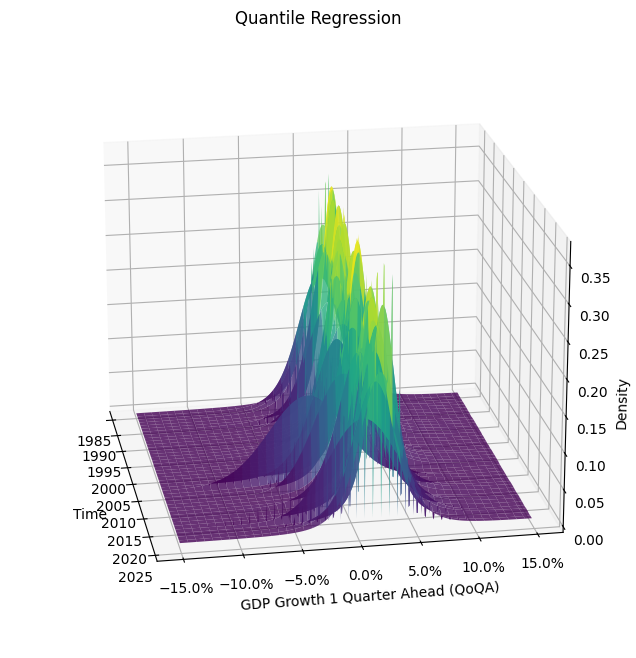

In [11]:
support_aux = np.arange(-15, 15.1, 0.1)
# Limit Dates_forecast_num to the length of T (to avoid shape mismatch)
Dates_forecast_num = np.arange(df.index[0].year + 0.25 * (df.index[0].quarter - 1),
                               df.index[T-1].year + 0.25 * (df.index[T-1].quarter - 1) + 0.25, 0.25)

# Recreate the meshgrid based on the new Dates_forecast_num length
X_grid_aux, Y_grid_aux = np.meshgrid(Dates_forecast_num, support_aux)

# Reinitialize the linreg_Z and quantile_Z arrays to ensure correct shapes
linreg_Z = np.zeros((T, len(support_aux)))
quantile_Z = np.zeros((T, len(support_aux)))

# Loop through each time step to calculate the densities
for t_aux in range(T):
    # Compute the mean for the linear regression density using all three predictors
    mu_aux = np.dot([1, df['CISS'].iloc[t_aux], df['g_RGDP_original'].iloc[t_aux]], model.params)  # Using the linear model's parameters
    linreg_Z[t_aux, :] = norm.pdf(support_aux, loc=mu_aux, scale=linreg_sigma)
    
    # Compute the density for the quantile regression using the skewed t-distribution
    quantile_Z[t_aux, :] = dskt(support_aux, tdist_mu[t_aux], tdist_sigma[t_aux], tdist_alpha[t_aux], tdist_nu[t_aux])

# Adjust quantile_Z to match the dimensions of X_grid_aux and Y_grid_aux
quantile_Z = quantile_Z[:len(Dates_forecast_num), :]

# 3D plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_grid_aux, Y_grid_aux, quantile_Z.T, cmap='viridis', edgecolor='none', alpha=.8)
ax.view_init(20, -10)
ax.set_title('Quantile Regression')
ax.set_xlabel('Time')
ax.set_ylabel(label_text)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_zlabel('Density')
plt.show()

Skewed t-distribution parameters over time

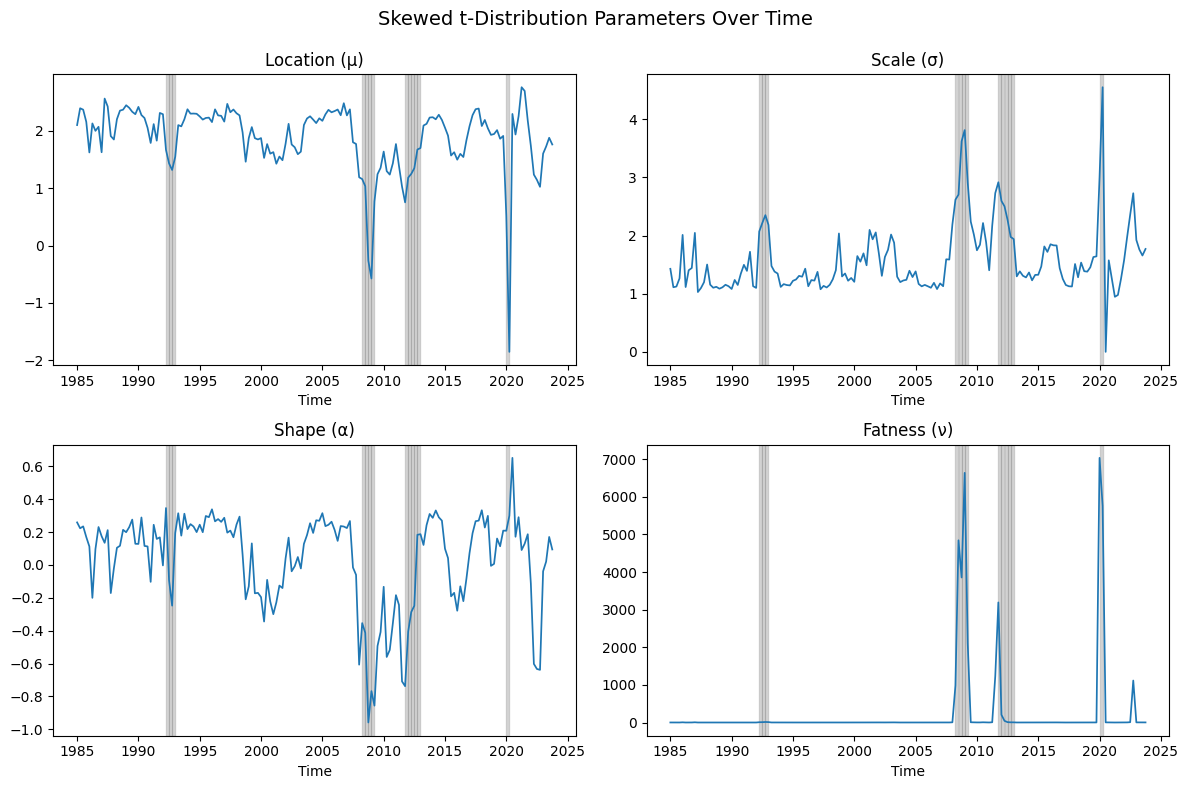

In [12]:
# Plot Skewed t-Distribution Parameters over time
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Skewed t-Distribution Parameters Over Time', fontsize=14)

# Subplot 1: Location (mu)
axs[0, 0].plot(df.index, tdist_mu, linewidth=1.25)
add_recession_shading(axs[0, 0], recession_dates)
axs[0, 0].set_title('Location (μ)')
axs[0, 0].set_xlabel('Time')

# Subplot 2: Scale (sigma)
axs[0, 1].plot(df.index, tdist_sigma, linewidth=1.25)
add_recession_shading(axs[0, 1], recession_dates)
axs[0, 1].set_title('Scale (σ)')
axs[0, 1].set_xlabel('Time')

# Subplot 3: Shape (alpha)
axs[1, 0].plot(df.index, tdist_alpha, linewidth=1.25)
add_recession_shading(axs[1, 0], recession_dates)
axs[1, 0].set_title('Shape (α)')
axs[1, 0].set_xlabel('Time')

# Subplot 4: Fatness (nu)
axs[1, 1].plot(df.index, tdist_nu, linewidth=1.25)
add_recession_shading(axs[1, 1], recession_dates)
axs[1, 1].set_title('Fatness (ν)')
axs[1, 1].set_xlabel('Time')

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Expected Shortfall and Longrise

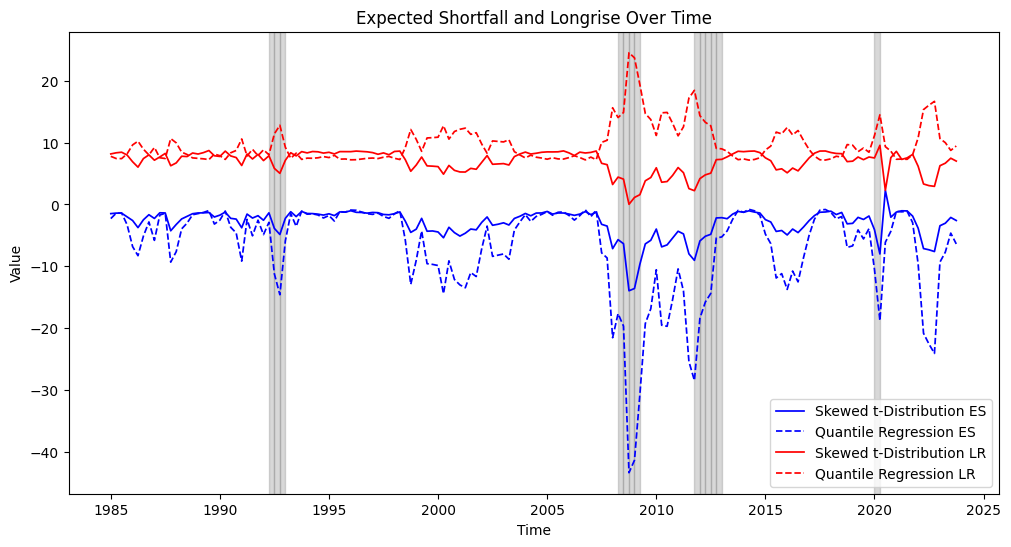

In [13]:
# Define quantile targets for Expected Shortfall and Longrise
quantile_targets_ES = [0.01, 0.02, 0.03, 0.04, 0.05]
quantile_targets_LR = [0.95, 0.96, 0.97, 0.98, 0.99]

# Perform quantile regression for the specified quantiles
def perform_quantile_regression(X, y, quantile_levels):
    quantile_fitted = np.zeros((len(X), len(quantile_levels)))
    for i, q in enumerate(quantile_levels):
        model = sm.QuantReg(y, X).fit(q=q)
        quantile_fitted[:, i] = model.predict(X)
    return quantile_fitted

# Add intercept to the predictor matrix
X_with_intercept = sm.add_constant(df['CISS'])

# Perform quantile regression for Expected Shortfall and Longrise
quantile_ES_aux = perform_quantile_regression(X_with_intercept, y, quantile_targets_ES)
quantile_LR_aux = perform_quantile_regression(X_with_intercept, y, quantile_targets_LR)

# Compute the fitted Expected Shortfall and Longrise
quantile_ES_fitted = np.mean(quantile_ES_aux, axis=1)
quantile_LR_fitted = np.mean(quantile_LR_aux, axis=1)

# Fitted Skewed t-Distribution
tdist_quantiles_ES = np.zeros((T, len(quantile_targets_ES)))
tdist_quantiles_LR = np.zeros((T, len(quantile_targets_LR)))

# Calculate the quantiles of the skewed t-distribution
for ti in range(T):
    for index, quantile_aux in enumerate(quantile_targets_ES):
        tdist_quantiles_ES[ti, index] = qskt(quantile_aux, tdist_mu[ti], tdist_sigma[ti], tdist_alpha[ti], tdist_nu[ti])
    for index, quantile_aux in enumerate(quantile_targets_LR):
        tdist_quantiles_LR[ti, index] = qskt(quantile_aux, tdist_mu[ti], tdist_sigma[ti], tdist_alpha[ti], tdist_nu[ti])

# Calculate the fitted Expected Shortfall and Longrise for the skewed t-distribution
tdist_ES_fitted = np.mean(tdist_quantiles_ES, axis=1)
tdist_LR_fitted = np.mean(tdist_quantiles_LR, axis=1)

# Plotting the Expected Shortfall and Longrise
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, tdist_ES_fitted, label='Skewed t-Distribution ES', color='blue', linewidth=1.25)
ax.plot(df.index, quantile_ES_fitted, linestyle='--', color='blue', linewidth=1.25, label='Quantile Regression ES')
ax.plot(df.index, tdist_LR_fitted, label='Skewed t-Distribution LR', color='red', linewidth=1.25)
ax.plot(df.index, quantile_LR_fitted, linestyle='--', color='red', linewidth=1.25, label='Quantile Regression LR')
# Add recession shading
add_recession_shading(ax, recession_dates)
# Adding labels, title, and legend
ax.set_title('Expected Shortfall and Longrise Over Time')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()

# Display the plot
plt.show()

Plot the densities for different dates

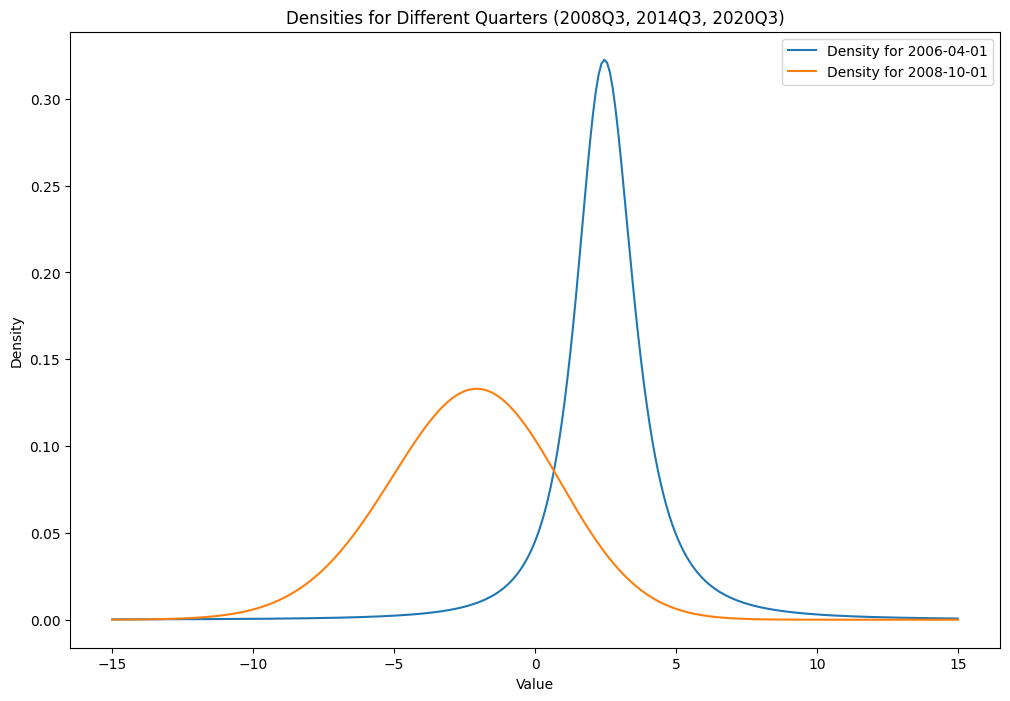

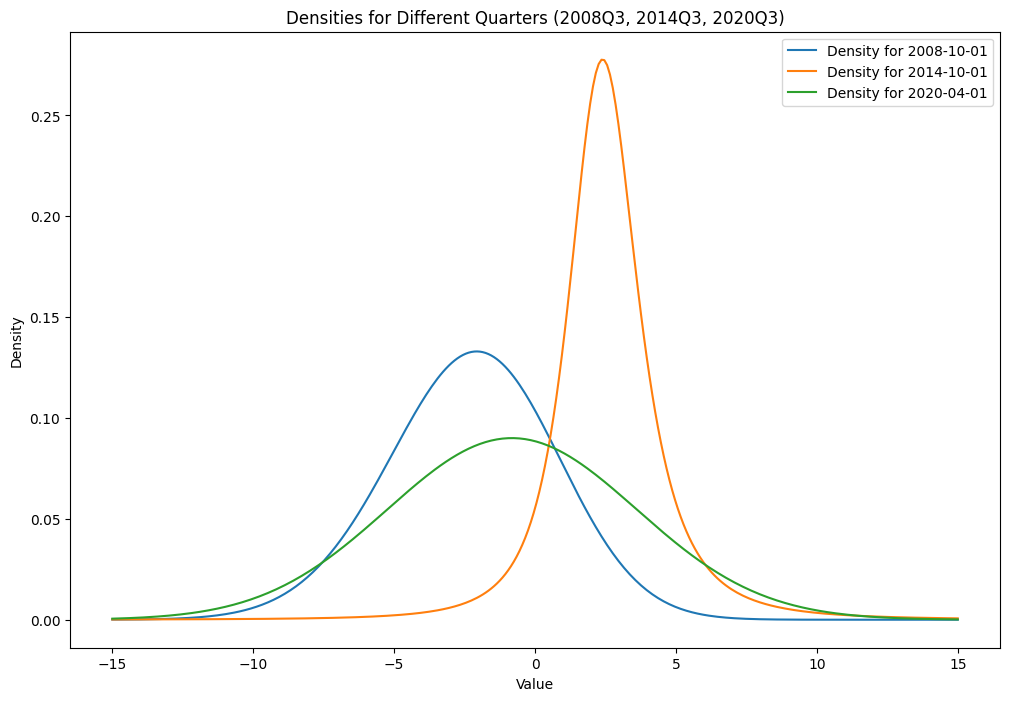

In [14]:
# Define the quarters to plot
quarters_to_plot = ['2006-04-01', '2008-10-01']

# Create an array for the support (x-axis) over which the density will be computed
support_aux = np.linspace(-15, 15, 300)  # Create a fine grid from -15 to 15

# Initialize a figure for plotting
plt.figure(figsize=(12, 8))

# Plot the densities for the specified quarters
for quarter in quarters_to_plot:
    # Find the index corresponding to the given date
    idx = df.index.get_loc(quarter)
    
    # Get the parameters for the skewed t-distribution at the specified date
    mu = tdist_mu[idx]
    sigma = tdist_sigma[idx]
    alpha = tdist_alpha[idx]
    nu = tdist_nu[idx]
    
    # Compute the density using the dskt function
    density = dskt(support_aux, mu, sigma, alpha, nu)
    
    # Plot the density
    plt.plot(support_aux, density, label=f'Density for {quarter}', linewidth=1.5)

# Add labels and title
plt.title('Densities for Different Quarters (2008Q3, 2014Q3, 2020Q3)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Display the plot
plt.show()

# Define the quarters to plot
quarters_to_plot = ['2008-10-01', '2014-10-01', '2020-04-01']

# Create an array for the support (x-axis) over which the density will be computed
support_aux = np.linspace(-15, 15, 300)  # Create a fine grid from -15 to 15

# Initialize a figure for plotting
plt.figure(figsize=(12, 8))

# Plot the densities for the specified quarters
for quarter in quarters_to_plot:
    # Find the index corresponding to the given date
    idx = df.index.get_loc(quarter)
    
    # Get the parameters for the skewed t-distribution at the specified date
    mu = tdist_mu[idx]
    sigma = tdist_sigma[idx]
    alpha = tdist_alpha[idx]
    nu = tdist_nu[idx]
    
    # Compute the density using the dskt function
    density = dskt(support_aux, mu, sigma, alpha, nu)
    
    # Plot the density
    plt.plot(support_aux, density, label=f'Density for {quarter}', linewidth=1.5)

# Add labels and title
plt.title('Densities for Different Quarters (2008Q3, 2014Q3, 2020Q3)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Display the plot
plt.show()

Scores for the predictions

In [15]:
# Initialize arrays to store the scores
linreg_scores = np.zeros(T)
tdist_scores = np.zeros(T)

# Calculate the score for the linear regression model
for ti in range(T):
    # Compute the linear regression score using the normal distribution PDF
    mu_linreg = np.dot([1, df['CISS'].iloc[ti], df['g_RGDP_original'].iloc[ti]], model.params)  # Predicted mean
    linreg_scores[ti] = norm.pdf(y.iloc[ti], loc=mu_linreg, scale=linreg_sigma)

# Calculate the score for the skewed t-distribution
for ti in range(T):
    # Compute the skewed t-distribution score using the dskt function
    tdist_scores[ti] = dskt(y.iloc[ti], tdist_mu[ti], tdist_sigma[ti], tdist_alpha[ti], tdist_nu[ti])

Plot the scores

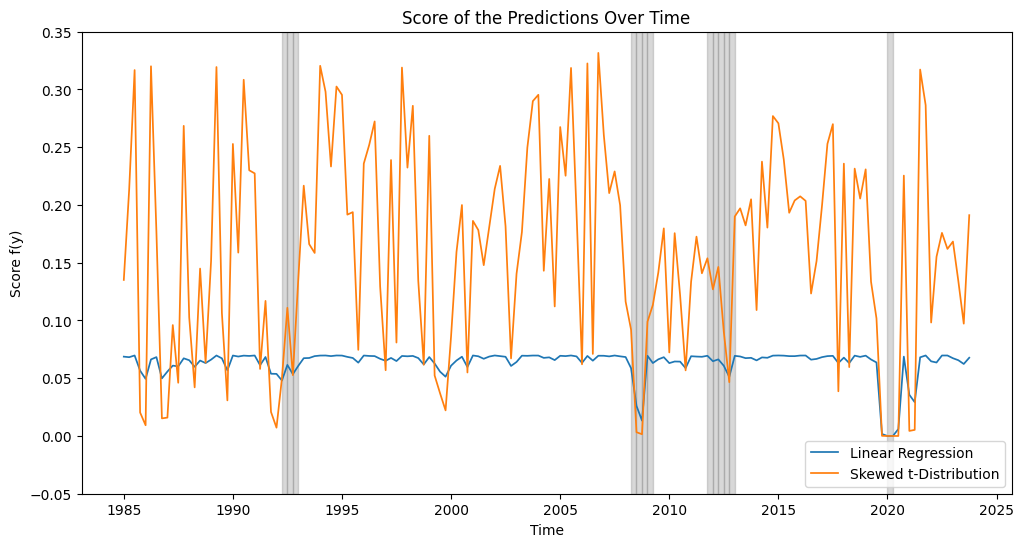

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, linreg_scores, label='Linear Regression', linewidth=1.25)
ax.plot(df.index, tdist_scores, label='Skewed t-Distribution', linewidth=1.25)

# Add recession shading to the plot
add_recession_shading(ax, recession_dates)

# Setting plot title, labels, and legend
ax.set_title('Score of the Predictions Over Time')
ax.set_ylabel('Score f(y)')
ax.set_xlabel('Time')
ax.set_ylim([-0.05, 0.35])
ax.legend()

# Display the plot
plt.show()

Compare with GDP only

In [17]:
# Alternative predictor variable set including the intercept and shifted GDP growth
X_alt = pd.DataFrame({'Intercept': 1, 'GDP': df['g_RGDP_original']})  # Shift GDP growth by +h

# Drop rows with NaN values in the shifted GDP growth
X_alt.dropna(inplace=True)

# Update y to match the indices of X_alt after dropping NaNs
y_alt = y.loc[y.index.isin(X_alt.index)]
 
# Perform linear regression using the original predictor variables (CISS)
model_CISS = sm.OLS(y, X).fit()
linreg_sigma_CISS = np.std(model_CISS.resid)

# Perform linear regression using the alternative predictor variables (GDP)
model_GDP = sm.OLS(y_alt, X_alt).fit()
linreg_sigma_GDP = np.std(model_GDP.resid)

# Perform quantile regression for both models
quantile_levels = [0.05, 0.25, 0.5, 0.75, 0.95]  # Target quantiles

# Quantile regression for CISS predictor
quantile_fitted_CISS = np.zeros((len(X), len(quantile_levels)))
for i, q in enumerate(quantile_levels):
    quantile_model_CISS = sm.QuantReg(y, X).fit(q=q)
    quantile_fitted_CISS[:, i] = quantile_model_CISS.predict(X)

# Quantile regression for GDP predictor
quantile_fitted_GDP = np.zeros((len(X_alt), len(quantile_levels)))
for i, q in enumerate(quantile_levels):
    quantile_model_GDP = sm.QuantReg(y_alt, X_alt).fit(q=q)
    quantile_fitted_GDP[:, i] = quantile_model_GDP.predict(X_alt)

Calculate the scores for both models

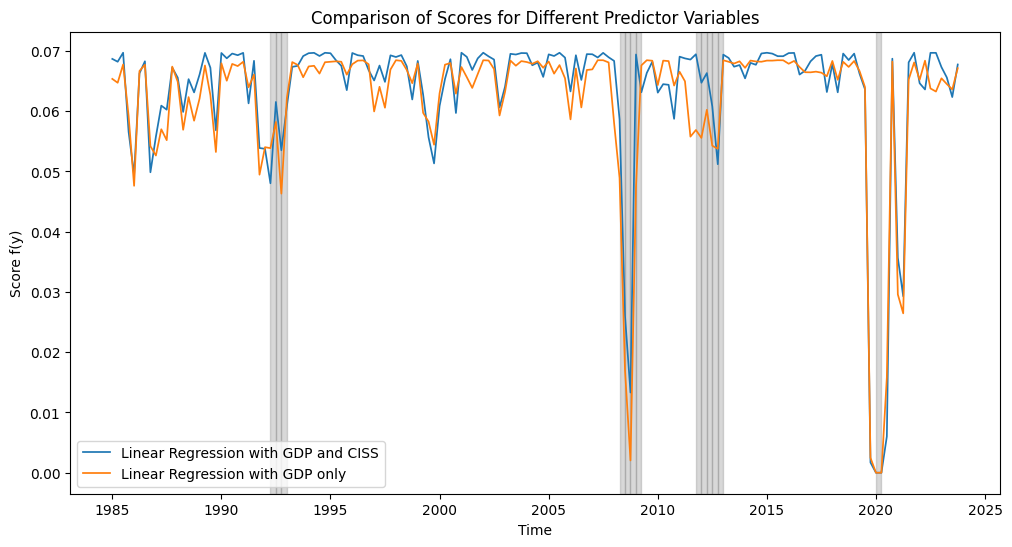

In [18]:
# Initialize arrays to store the scores
linreg_scores_CISS = np.zeros(T)
linreg_scores_GDP = np.zeros(T)
quantile_scores_CISS = np.zeros(T)
quantile_scores_GDP = np.zeros(T)

# Scores for linear regression
for ti in range(T):
    # Compute the linear regression score using the normal distribution PDF for CISS model
    if ti < len(X):
        # Include all predictors: Intercept, CISS, and GDP
        predictors_CISS = [1, df['CISS'].iloc[ti], df['g_RGDP_original'].iloc[ti]]
        mu_linreg_CISS = np.dot(predictors_CISS, model_CISS.params)
        linreg_scores_CISS[ti] = norm.pdf(y.iloc[ti], loc=mu_linreg_CISS, scale=linreg_sigma_CISS)
    
    # Compute the linear regression score using the normal distribution PDF for GDP model
    if ti < len(X_alt):
        # Use only the predictors included in model_GDP (Intercept and GDP)
        predictors_GDP = [1, X_alt['GDP'].iloc[ti]]
        mu_linreg_GDP = np.dot(predictors_GDP, model_GDP.params)
        linreg_scores_GDP[ti] = norm.pdf(y.iloc[ti], loc=mu_linreg_GDP, scale=linreg_sigma_GDP)

# Compare the scores for the two predictor sets
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, linreg_scores_CISS, label='Linear Regression with GDP and CISS', linewidth=1.25)
ax.plot(df.index, linreg_scores_GDP, label='Linear Regression with GDP only', linewidth=1.25)

# Add recession shading
add_recession_shading(ax, recession_dates)

# Set title, labels, and legend
ax.set_title('Comparison of Scores for Different Predictor Variables')
ax.set_xlabel('Time')
ax.set_ylabel('Score f(y)')
ax.legend()

# Show the plot
plt.show()

Calculate the scores for the Skewed t-distribution with different predictors

Iteration: 1/156
Iteration: 2/156
Iteration: 3/156
Iteration: 4/156
Iteration: 5/156
Iteration: 6/156
Iteration: 7/156
Iteration: 8/156
Iteration: 9/156
Iteration: 10/156
Iteration: 11/156
Iteration: 12/156
Iteration: 13/156
Iteration: 14/156
Iteration: 15/156
Iteration: 16/156
Iteration: 17/156
Iteration: 18/156
Iteration: 19/156
Iteration: 20/156
Iteration: 21/156
Iteration: 22/156
Iteration: 23/156
Iteration: 24/156
Iteration: 25/156
Iteration: 26/156
Iteration: 27/156
Iteration: 28/156
Iteration: 29/156
Iteration: 30/156
Iteration: 31/156
Iteration: 32/156
Iteration: 33/156
Iteration: 34/156
Iteration: 35/156
Iteration: 36/156
Iteration: 37/156
Iteration: 38/156
Iteration: 39/156
Iteration: 40/156
Iteration: 41/156
Iteration: 42/156
Iteration: 43/156
Iteration: 44/156
Iteration: 45/156
Iteration: 46/156
Iteration: 47/156
Iteration: 48/156
Iteration: 49/156
Iteration: 50/156
Iteration: 51/156
Iteration: 52/156
Iteration: 53/156
Iteration: 54/156
Iteration: 55/156
Iteration: 56/156
I

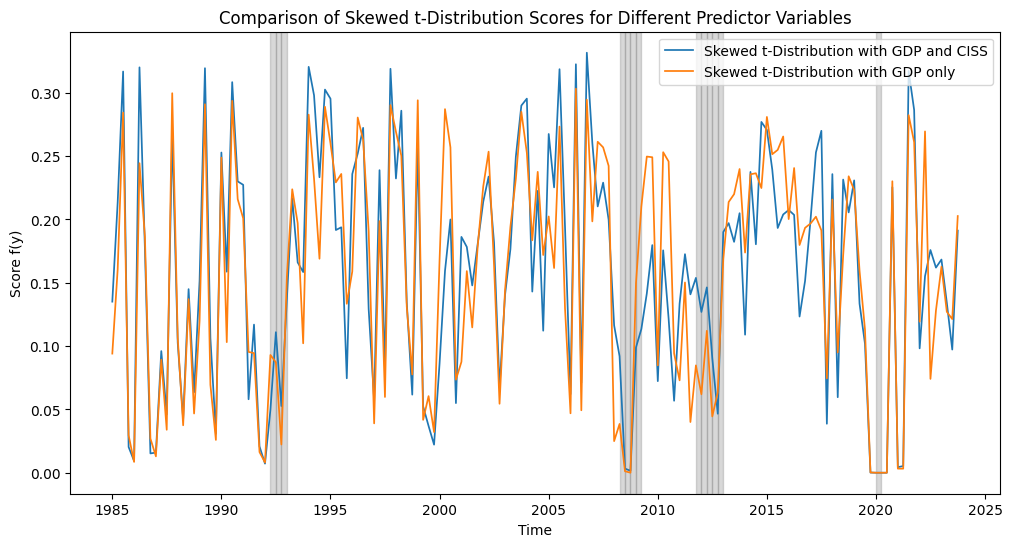

In [19]:
#Fit a Skewed t-distribution
# Define the target quantiles for interpolation
quantile_targets_t = [0.05, 0.25, 0.75, 0.95]

# Initialize arrays to store the results
T = len(df)  # Assuming 'df' has the time series data
tdist_mu_alt = np.zeros(T)
tdist_sigma_alt = np.zeros(T)
tdist_alpha_alt = np.zeros(T)
tdist_nu_alt = np.zeros(T)

# Loop through each time step to fit the skewed t-distribution
for t_aux in range(T):
    print(f"Iteration: {t_aux + 1}/{T}")
    quantiles_to_fit = quantile_fitted_GDP[t_aux, [0, 1, 3, 4]]  # Q05, Q25, Q75, Q95
    tdist_mu_alt[t_aux], tdist_sigma_alt[t_aux], tdist_alpha_alt[t_aux], tdist_nu_alt[t_aux] = quantiles_interpolation(quantiles_to_fit, quantile_targets_t)

# Initialize arrays to store the Skewed t-distribution scores for both models
tdist_scores_CISS = np.zeros(T)
tdist_scores_GDP = np.zeros(T)

# Calculate Skewed t-distribution scores
for ti in range(T):
    # Skewed t-distribution score for CISS model
    if ti < len(X):
        tdist_scores_CISS[ti] = dskt(y.iloc[ti], tdist_mu[ti], tdist_sigma[ti], tdist_alpha[ti], tdist_nu[ti])
    
    # Skewed t-distribution score for GDP model
    if ti < len(X_alt):
        # Recalculate Skewed t-distribution parameters for GDP only model
        mu_gdp = tdist_mu_alt[ti]
        sigma_gdp = tdist_sigma_alt[ti]
        alpha_gdp = tdist_alpha_alt[ti]
        nu_gdp = tdist_nu_alt[ti]
        # Calculate the score for the GDP-only model
        tdist_scores_GDP[ti] = dskt(y.iloc[ti], mu_gdp, sigma_gdp, alpha_gdp, nu_gdp)

# Compare the Skewed t-distribution scores for the two predictor sets
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, tdist_scores_CISS, label='Skewed t-Distribution with GDP and CISS', linewidth=1.25)
ax.plot(df.index, tdist_scores_GDP, label='Skewed t-Distribution with GDP only', linewidth=1.25)

# Add recession shading
add_recession_shading(ax, recession_dates)

# Set title, labels, and legend
ax.set_title('Comparison of Skewed t-Distribution Scores for Different Predictor Variables')
ax.set_xlabel('Time')
ax.set_ylabel('Score f(y)')
ax.legend()

# Show the plot
plt.show()

Out-of-Sample PIT Calculation and Specification Test

c:\Users\JABAMI\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\JABAMI\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\JABAMI\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\JABAMI\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum nu

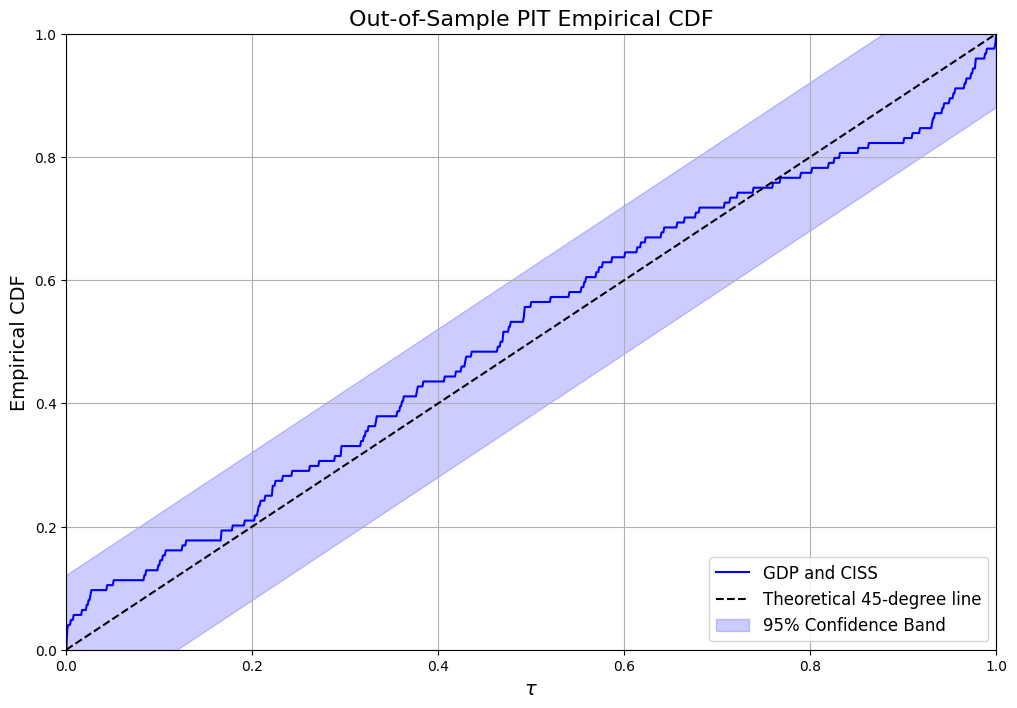

In [20]:
# Set a limit for minimization iterations
minimize_iter_max = 100

# Function to compute the quantile for the skewed t-distribution
def qskt(p, mu, sigma, alpha, nu):
    """
    Calculate the quantile for the skewed t-distribution.
    """
    quantile = mu + sigma * t.ppf(p, df=nu) * (1 + alpha * np.sign(p - 0.5))
    return quantile

# Function to perform quantile interpolation for skewed t-distribution
def quantiles_interpolation(quantiles, quantile_targets):
    """
    Fit the parameters of the skewed t-distribution to the provided quantiles.
    """
    def objective(params):
        mu, sigma, alpha, nu = params
        theoretical_quantiles = [qskt(q, mu, sigma, alpha, nu) for q in quantile_targets]
        error = np.sum((np.array(theoretical_quantiles) - np.array(quantiles)) ** 2)
        return error

    initial_guess = [0, 1, 0, 5]
    bounds = [(-np.inf, np.inf), (1e-6, np.inf), (-np.inf, np.inf), (2, np.inf)]
    result = minimize(objective, initial_guess, bounds=bounds, options={'maxiter': minimize_iter_max})
    mu, sigma, alpha, nu = result.x
    return mu, sigma, alpha, nu

# Function to calculate the cumulative distribution function of the skewed t-distribution
def pskt(x, mu, sigma, alpha, nu):
    """
    Calculate the cumulative distribution function (CDF) for the skewed t-distribution.
    """
    z = (x - mu) / sigma
    cdf_value = t.cdf(z * (1 + alpha * np.sign(z)), df=nu)
    return cdf_value

# Function to calculate the empirical CDF of PIT values
def empirical_cdf(pit_values, rvec):
    """
    Compute the empirical cumulative distribution function (CDF) of the PIT values.
    """
    sorted_pits = np.sort(pit_values)
    empirical_cdf_values = np.searchsorted(sorted_pits, rvec, side='right') / len(sorted_pits)
    return empirical_cdf_values

# Load the data
df = pd.read_excel('data/Data_Adrian_2019_usa&EA.xlsx', sheet_name='EA_Quarterly')
df.index = pd.to_datetime(df.Date)
df.sort_index(inplace=True)
df['Intercept'] = 1

# Define forecasting horizon
h = 1  # Set to 1 for one-quarter ahead prediction
ycol = 'g_RGDP' if h == 1 else 'g_RGDPyoy'
df['g_RGDP_original'] = df[ycol]
df[ycol] = df[ycol].shift(-h)
df.dropna(subset=['CISS', ycol, 'g_RGDP_original'], inplace=True)

# Determine the starting index for out-of-sample prediction
jtFirstOOS = df.index.get_loc(pd.Timestamp('1993-01-01'))

# Out-of-Sample Quantile Regression with CISS and GDP
rolling_window_size = 30
quantile_levels = [0.05, 0.25, 0.5, 0.75, 0.95]
T_oos = len(df) - jtFirstOOS

quantile_fitted_oos = np.zeros((T_oos, len(quantile_levels)))

# Perform quantile regression with a rolling window approach
for ti in range(jtFirstOOS, len(df)):
    # Use data up to the current time step `ti` (rolling window)
    train_df = df.iloc[ti - rolling_window_size:ti]
    X_train = sm.add_constant(train_df[['CISS', 'g_RGDP_original']])
    y_train = train_df[ycol]

    # Estimate quantiles for each quantile level
    for i, q in enumerate(quantile_levels):
        quantile_model = sm.QuantReg(y_train, X_train).fit(q=q)
        quantile_fitted_oos[ti - jtFirstOOS, i] = quantile_model.predict([1, df['CISS'].iloc[ti], df['g_RGDP_original'].iloc[ti]])[0]

# Fit Skewed t-Distribution for each out-of-sample time step
tdist_mu_oos = np.zeros(T_oos)
tdist_sigma_oos = np.zeros(T_oos)
tdist_alpha_oos = np.zeros(T_oos)
tdist_nu_oos = np.zeros(T_oos)

quantile_targets = [0.05, 0.25, 0.75, 0.95]

# Fit skewed-t distribution using the quantile estimates
for ti in range(T_oos):
    quantiles_to_fit = quantile_fitted_oos[ti, [0, 1, 3, 4]]
    mu, sigma, alpha, nu = quantiles_interpolation(quantiles_to_fit, quantile_targets)
    tdist_mu_oos[ti], tdist_sigma_oos[ti], tdist_alpha_oos[ti], tdist_nu_oos[ti] = mu, sigma, alpha, nu

# Calculate PIT values
def calculate_pits_oos(y_true, params):
    """
    Calculate the Probability Integral Transform (PIT) values for out-of-sample data.
    """
    pits = np.zeros(len(y_true))
    for i in range(len(y_true)):
        mu, sigma, alpha, nu = params[i]
        pits[i] = pskt(y_true[i], mu, sigma, alpha, nu)
    return pits

# Generate PITs for out-of-sample predictions
y_oos = df[ycol].iloc[jtFirstOOS:].values
skewed_t_params_oos = [(tdist_mu_oos[i], tdist_sigma_oos[i], tdist_alpha_oos[i], tdist_nu_oos[i]) for i in range(T_oos)]
pits_skewed_t_oos = calculate_pits_oos(y_oos, skewed_t_params_oos)

# Set rvec for plotting
rvec = np.arange(0, 1.001, 0.001)

# Calculate empirical CDF for the PIT values
zST_ecdf = empirical_cdf(pits_skewed_t_oos, rvec)

# Determine critical values for the PIT test
kappa = 1.34  # Asymptotic critical value for h=1

# Plot the PITs empirical CDF vs. theoretical CDF
plt.figure(figsize=(12, 8))
plt.plot(rvec, zST_ecdf, '-b', label='GDP and CISS')
plt.plot(rvec, rvec, 'k--', label='Theoretical 45-degree line')
plt.fill_between(rvec, rvec - (kappa / np.sqrt(len(pits_skewed_t_oos))), 
                 rvec + (kappa / np.sqrt(len(pits_skewed_t_oos))), color='b', alpha=0.2, label='95% Confidence Band')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'$\tau$', fontsize=14)
plt.ylabel('Empirical CDF', fontsize=14)
plt.title('Out-of-Sample PIT Empirical CDF', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()

Out-of-Sample PIT Calculation and Specification Test with SPF